In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
import scipy.stats

In [2]:
target = 150

In [3]:
smb = pd.read_csv("month_factors.csv")

In [4]:
smb["del x"] = np.nan
smb["abs dist"] = abs(smb["SMB"] - smb.iloc[target-1]["SMB"])
for i in range(smb.shape[0]-1):
    smb.loc[i, "del x"] = smb["SMB"][i+1] - smb["SMB"][i]

In [5]:
smb

,Date,Mkt-RF,SMB,HML,RF,del x,abs dist
0,1990-07-31,0.035909,0.022727,-0.015909,0.03,-0.103162,0.055000
1,1990-08-31,-0.478261,-0.080435,0.020000,0.03,0.152435,0.158162
2,1990-09-30,-0.624000,0.072000,0.044000,0.03,-0.387652,0.005727
3,1990-10-31,0.394348,-0.315652,-0.185217,0.03,0.378834,0.393379
4,1990-11-30,-0.166364,0.063182,0.050000,0.03,-0.097944,0.014545
...,...,...,...,...,...,...,...
378,2022-01-31,-0.268571,-0.208095,0.595714,0.00,0.295595,0.285823
379,2022-02-28,-0.108000,0.087500,0.139000,0.00,-0.166196,0.009773
380,2022-03-31,0.103043,-0.078696,-0.056522,0.00,0.060124,0.156423
381,2022-04-30,-0.400000,-0.018571,0.252857,0.00,-0.039156,0.096299


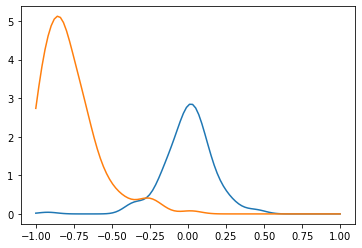

In [6]:
delspace = np.linspace(-1,1,100)
delkernel = scipy.stats.gaussian_kde(np.array(smb["del x"][0:target]))

distspace = np.linspace(0,1,100)
distkernel = scipy.stats.gaussian_kde(np.array(smb["abs dist"][0:target]))

plt.plot(delspace, delkernel.evaluate(delspace))
plt.plot(delspace, distkernel.evaluate(distspace))

In [7]:
delx_weights = np.zeros((len(smb["del x"][:target]), 1))

In [8]:
for i in range(len(smb["del x"][:target])):
    delx_weights[i][0] = distkernel.evaluate(smb["abs dist"][i])

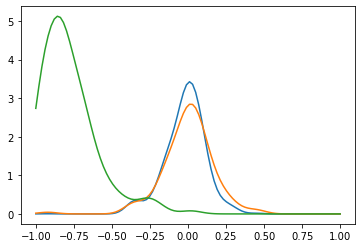

In [9]:
wdelkernel = scipy.stats.gaussian_kde(np.array(smb["del x"][:target]), weights=delx_weights[:].ravel())

plt.plot(delspace, wdelkernel.evaluate(delspace))
plt.plot(delspace, delkernel.evaluate(delspace))
plt.plot(delspace, distkernel.evaluate(distspace))

In [10]:
quad(lambda x: x*wdelkernel.evaluate(x), -1, 1)

(-0.018096351303710886, 3.1424233148913934e-11)

In [11]:
def predict_del_smb(smb, target, hist_range=150):
    smb["del x"] = np.nan
    smb["abs dist"] = abs(smb["SMB"] - smb.iloc[target-1]["SMB"])
    for i in range(target-hist_range, target+1):
        smb.loc[i, "del x"] = smb["SMB"][i+1] - smb["SMB"][i]

    distkernel = scipy.stats.gaussian_kde(np.array(smb["abs dist"][target-hist_range:target]))

    delx_weights = np.zeros((hist_range, 1))
    for i in range(hist_range):
        delx_weights[i][0] = distkernel.evaluate(smb["abs dist"][target-hist_range+i])

    wdelkernel = scipy.stats.gaussian_kde(np.array(smb["del x"][target-hist_range:target]), weights=delx_weights.ravel())

    return quad(lambda x: x*wdelkernel.evaluate(x), -1, 1)

In [12]:
predict_del_smb(pd.read_csv("month_factors.csv"), 151)

(-0.017615212981597878, 1.7837328187689367e-11)

In [13]:
hist_range = 150
smb["pred del x"] = np.nan
for i in range(hist_range,382):
    smb.loc[i, "pred del x"] = predict_del_smb(pd.read_csv("month_factors.csv"), i, hist_range=hist_range)[0]

In [14]:
smb

,Date,Mkt-RF,SMB,HML,RF,del x,abs dist,pred del x
0,1990-07-31,0.035909,0.022727,-0.015909,0.03,-0.103162,0.055000,NaN
1,1990-08-31,-0.478261,-0.080435,0.020000,0.03,0.152435,0.158162,NaN
2,1990-09-30,-0.624000,0.072000,0.044000,0.03,-0.387652,0.005727,NaN
3,1990-10-31,0.394348,-0.315652,-0.185217,0.03,0.378834,0.393379,NaN
4,1990-11-30,-0.166364,0.063182,0.050000,0.03,-0.097944,0.014545,NaN
...,...,...,...,...,...,...,...,...
378,2022-01-31,-0.268571,-0.208095,0.595714,0.00,0.295595,0.285823,0.014365
379,2022-02-28,-0.108000,0.087500,0.139000,0.00,-0.166196,0.009773,-0.000089
380,2022-03-31,0.103043,-0.078696,-0.056522,0.00,0.060124,0.156423,-0.008994
381,2022-04-30,-0.400000,-0.018571,0.252857,0.00,-0.039156,0.096299,0.014417


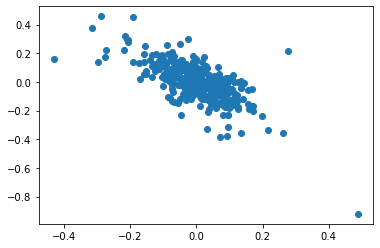

In [18]:
plt.scatter(smb["SMB"], smb["del x"])